# Imports

In [6]:
cd /home/tijmen/tudelft/thesis/metaengineering

/home/tijmen/tudelft/thesis/metaengineering


In [7]:
import os
import glob
import json
import ast
import re

from typing import Dict, List

from src.utils.parsers.cv_parser import fmt_cv_results
from src.utils.visualizers.prediction_figures import PredictionFigures
from src.utils.visualizers.test_figures import TestFigures
from src.utils.visualizers.cv_figures import CVFigures
from src.settings.strategy import Strategy
from src.settings.tier import Tier

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [8]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

def gather_results(paths: List[str]):
    metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
    df = pd.concat([
        pd.read_csv(path).assign(metabolite_id=metabolite_name) 
        for path, metabolite_name in zip(paths, metabolites_names)
    ])
    return df

def combine_metabolite_info(df):
    metabolite_info = get_metabolite_info()
    df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
    return df

In [9]:
metabolite_info = get_metabolite_info()

In [10]:
class ResultFetcher:
    def __init__(self, root_dir: str, metabolite_info: pd.DataFrame) -> None:
        self.root_dir = root_dir
        self.metabolite_info = metabolite_info
    
    def get_all(self, experiment_id: Tier):
        test_df_all = self.get_test_df_all(experiment_id)
        test_df_metabolite = self.get_test_df_metabolite(experiment_id)
        test_df_one_vs_all = self.get_test_df_one_vs_all(experiment_id)
        return test_df_all, test_df_metabolite, test_df_one_vs_all
    
    def get_test_df_all(self, experiment_id: Tier):
        df = self.get_frame(experiment_id, Strategy.ALL)
        df = df.assign(strategy='all').assign(experiment_id=experiment_id)
        return df
    
    def get_test_df_metabolite(self, experiment_id: Tier):
        df = self.get_frame(experiment_id, Strategy.METABOLITE_CENTRIC)
        df = df.assign(strategy='metabolite').assign(experiment_id=experiment_id)
        return df
    
    def get_test_df_one_vs_all(self, experiment_id: Tier):
        df = self.get_frame(experiment_id, Strategy.ONE_VS_ALL)
        df = df.assign(strategy='one_vs_all').assign(experiment_id=experiment_id)
        return df
        
    def get_frame(self, experiment_id: Tier, strategy: Strategy):
        path = f"{self.root_dir}/{experiment_id}/best_model_performance_{strategy}.csv"
        print(path)
        if self.file_exists(path):
            test_df_all = pd.read_csv(path, index_col=0)
            test_df_all = test_df_all.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
            test_df_all[['metabolite_id', 'architecture']] = test_df_all['metabolite_arch'].str.split("_", expand=True)
            test_df_all = test_df_all.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True)
            return test_df_all
    
    def file_exists(self, path: str):
        return os.path.exists(path)

In [11]:
result_fetcher = ResultFetcher(
    root_dir="/home/tijmen/tudelft/thesis/metaengineering/data/results",
    metabolite_info=metabolite_info
)

test_df_all = pd.concat([result_fetcher.get_test_df_all(i) for i in [Tier.TIER0, Tier.TIER1]])
test_df_metabolite = pd.concat([result_fetcher.get_test_df_metabolite(i) for i in [Tier.TIER0, Tier.TIER1]])
test_df_one_vs_all = pd.concat([result_fetcher.get_test_df_one_vs_all(i) for i in [Tier.TIER0, Tier.TIER1]])

test_df = pd.concat([test_df_all, test_df_metabolite, test_df_one_vs_all], axis=0)
test_df_arch_all = test_df[test_df['architecture'] == 'all']
test_df_arch_per_model = test_df[test_df['architecture'] != 'all']
test_figures = TestFigures(test_df_arch_all)

/home/tijmen/tudelft/thesis/metaengineering/data/results/Tier.TIER0/best_model_performance_Strategy.ALL.csv
/home/tijmen/tudelft/thesis/metaengineering/data/results/Tier.TIER1/best_model_performance_Strategy.ALL.csv
/home/tijmen/tudelft/thesis/metaengineering/data/results/Tier.TIER0/best_model_performance_Strategy.METABOLITE_CENTRIC.csv
/home/tijmen/tudelft/thesis/metaengineering/data/results/Tier.TIER1/best_model_performance_Strategy.METABOLITE_CENTRIC.csv
/home/tijmen/tudelft/thesis/metaengineering/data/results/Tier.TIER0/best_model_performance_Strategy.ONE_VS_ALL.csv
/home/tijmen/tudelft/thesis/metaengineering/data/results/Tier.TIER1/best_model_performance_Strategy.ONE_VS_ALL.csv


# R2 metric

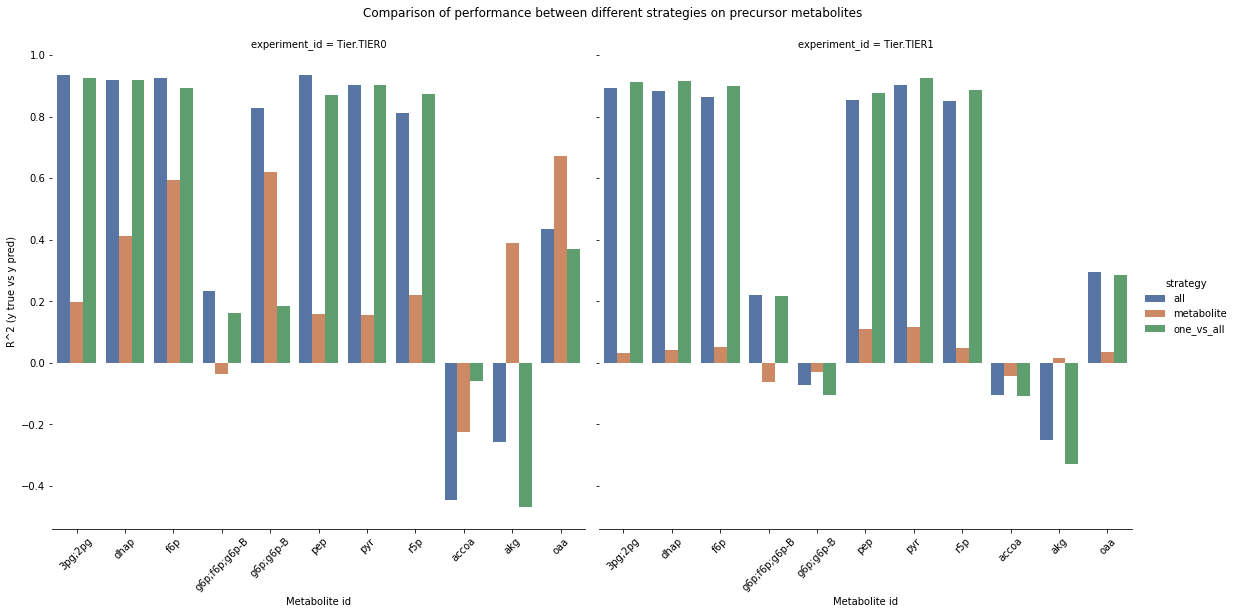

In [12]:
_df = test_df_arch_all.sort_values(['pathway', 'metabolite_id'])
g = sns.catplot(
    data=_df, 
    col='experiment_id',
    kind='bar',
    x='metabolite_id',
    y='r2',
    hue='strategy',
    palette='deep',
    height=8,
)
g.despine(left=True)
# g.set(yscale='symlog')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

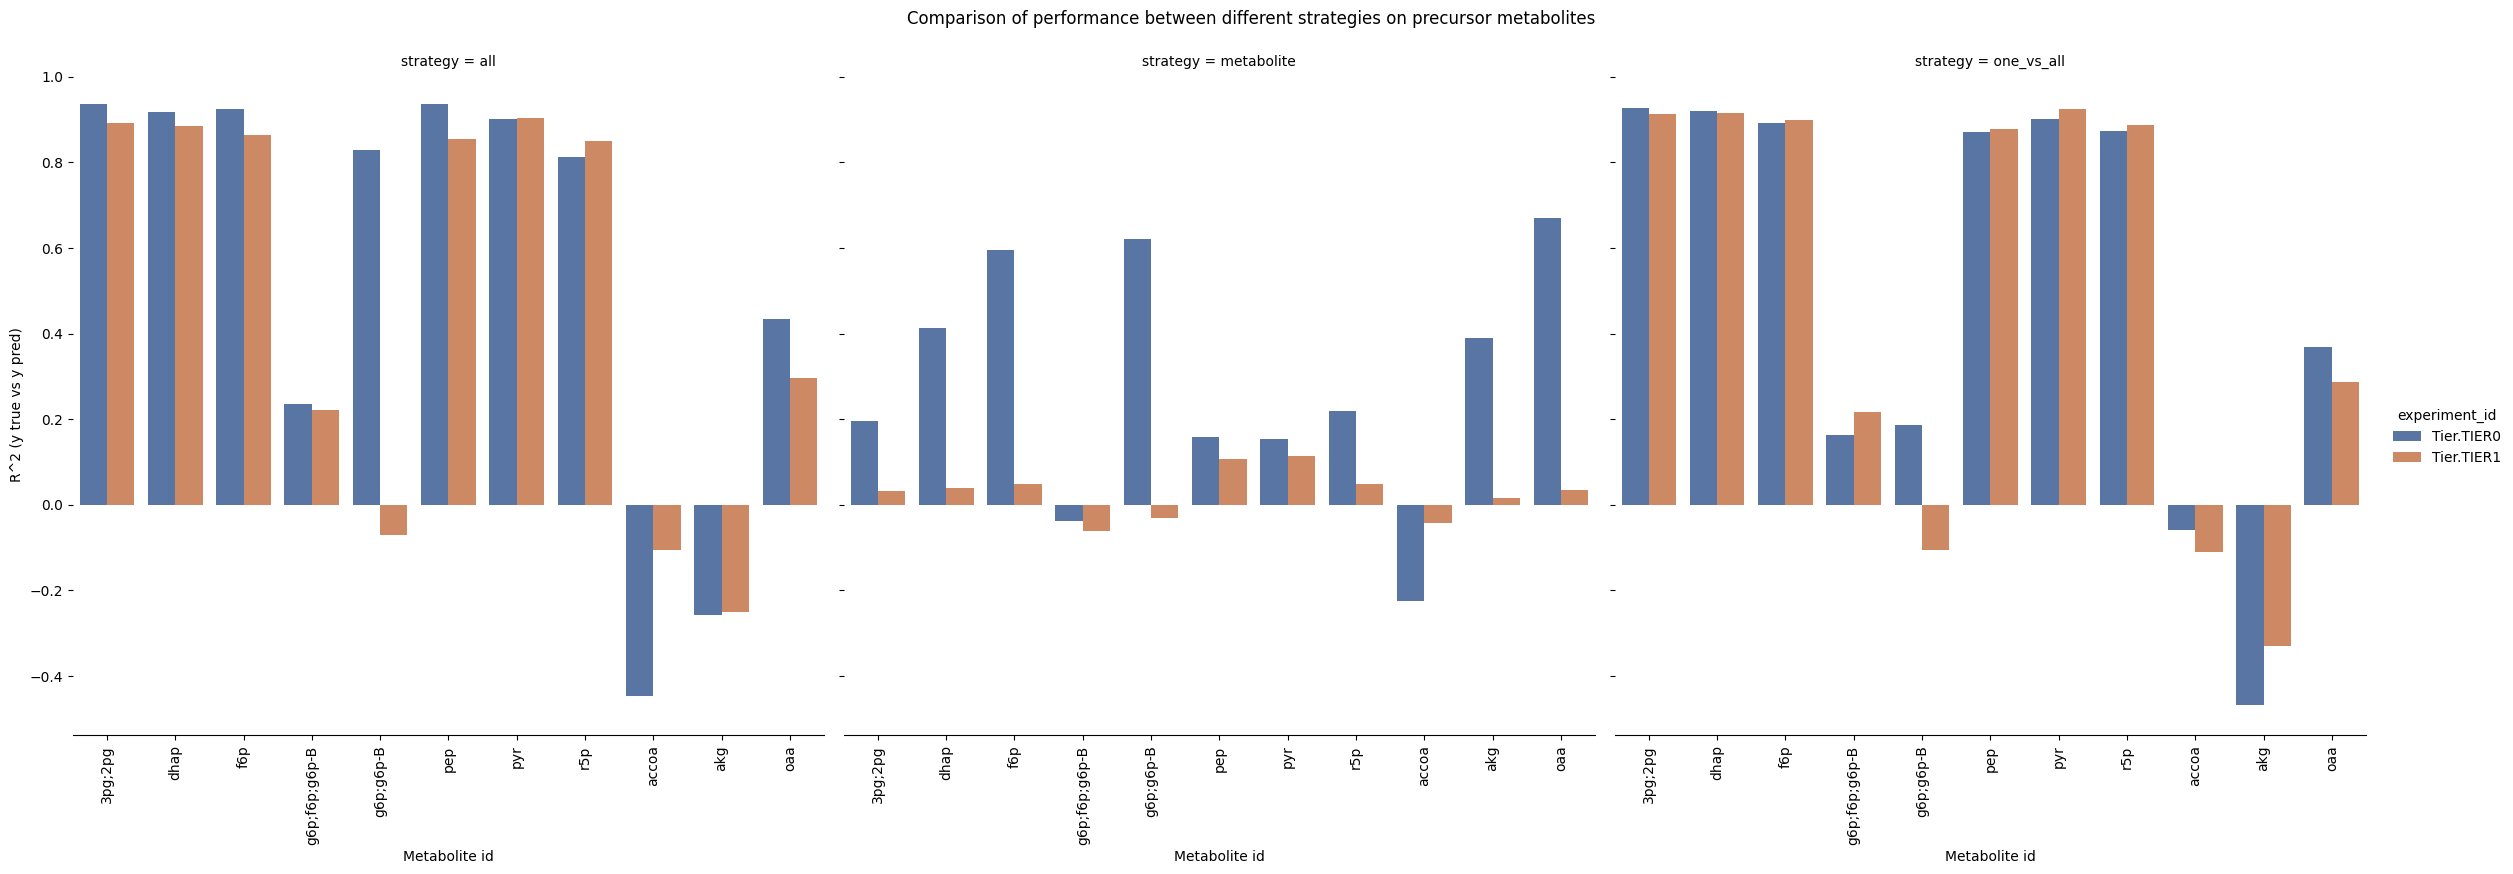

In [13]:
_df = test_df_arch_all.sort_values(['pathway', 'metabolite_id'])
g = sns.catplot(
    data=_df, 
    col='strategy',
    kind='bar',
    x='metabolite_id',
    y='r2',
    hue='experiment_id',
    palette='deep',
    height=8,
)
g.despine(left=True)
# g.set(yscale='symlog')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

In [14]:
test_df_arch_per_model

,r2,metabolite_id,architecture,official_name,kegg_id,pathway,method,Order,strategy,experiment_id
0,0.887930,pyr,SVR(),Pyruvate,C00022,Glycolysis,TCA,8,all,Tier.TIER0
0,0.972315,pyr,RandomForestRegressor(),Pyruvate,C00022,Glycolysis,TCA,8,all,Tier.TIER0
0,0.838608,pyr,ElasticNet(),Pyruvate,C00022,Glycolysis,TCA,8,all,Tier.TIER0
0,0.885628,r5p,SVR(),alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,all,Tier.TIER0
0,0.910770,r5p,RandomForestRegressor(),alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,all,Tier.TIER0
...,...,...,...,...,...,...,...,...,...,...
0,0.109414,pep,ElasticNet(),Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,one_vs_all,Tier.TIER1
0,0.925048,pyr,RandomForestRegressor(),Pyruvate,C00022,Glycolysis,TCA,8,one_vs_all,Tier.TIER1
0,0.100562,pyr,ElasticNet(),Pyruvate,C00022,Glycolysis,TCA,8,one_vs_all,Tier.TIER1
0,0.884571,r5p,RandomForestRegressor(),alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,one_vs_all,Tier.TIER1


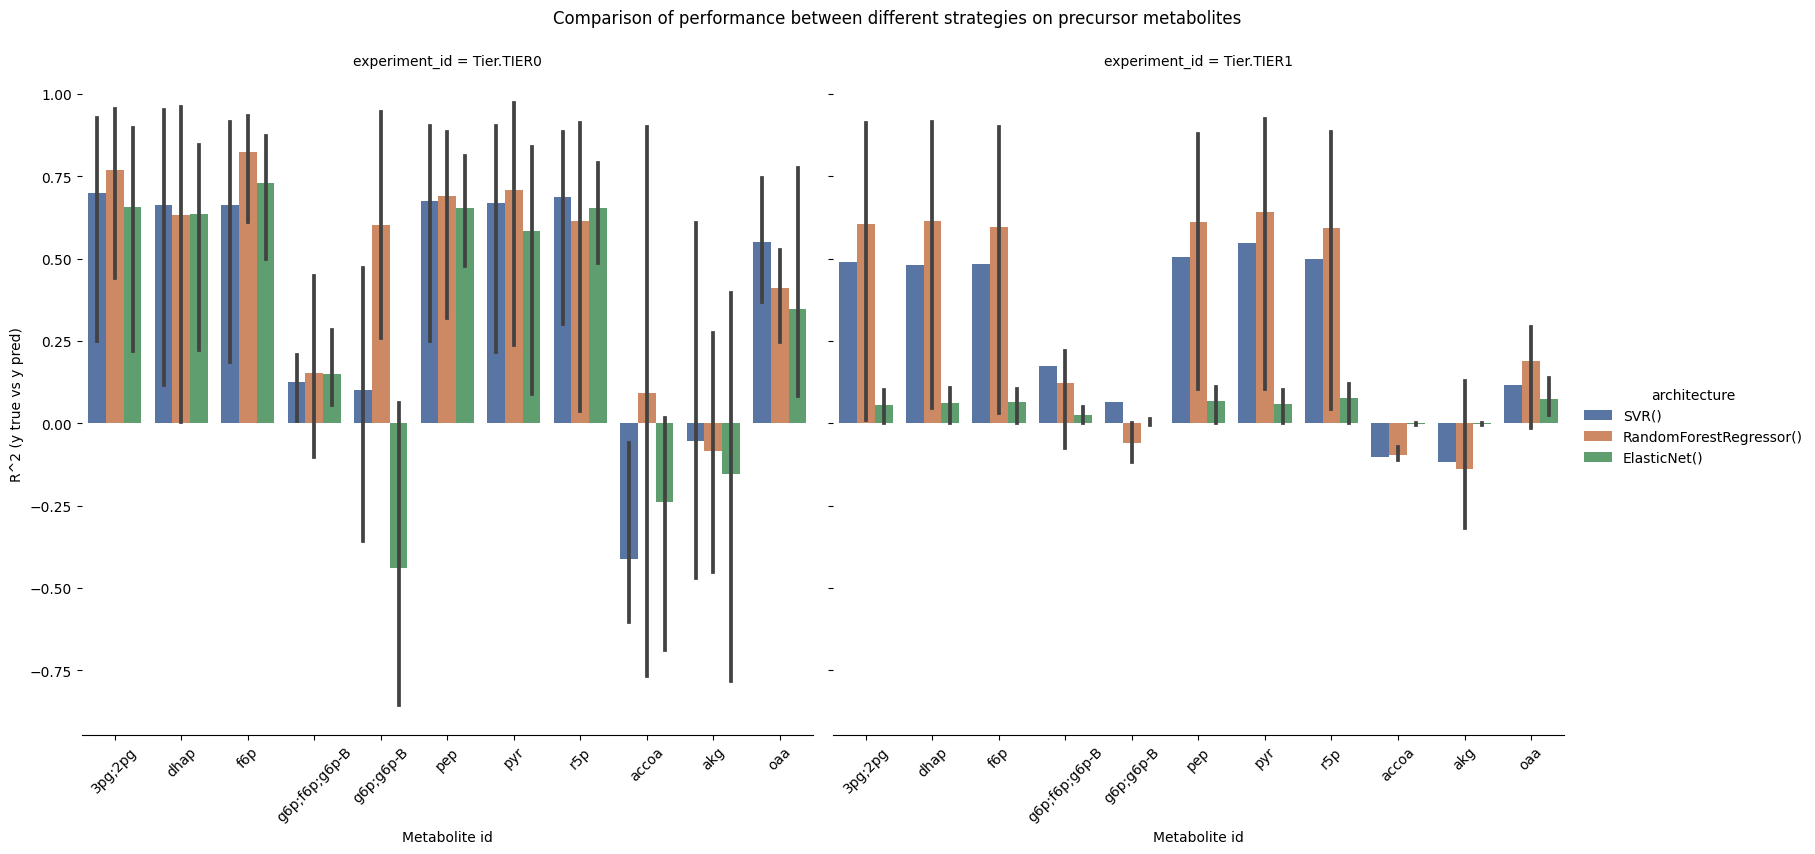

In [15]:
_df = test_df_arch_per_model.sort_values(['pathway', 'metabolite_id'])
g = sns.catplot(
    data=_df, 
    col='experiment_id',
    kind='bar',
    x='metabolite_id',
    y='r2',
    hue='architecture',
    palette='deep',
    height=8,
)
g.despine(left=True)
# g.set(yscale='symlog')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

# Accuracy metric

In [16]:
import itertools

tiers = [Tier.TIER0, Tier.TIER1]
strategies = [Strategy.ALL, Strategy.METABOLITE_CENTRIC, Strategy.ONE_VS_ALL]

def get_best_model_performance(tier, strategy):
    root_dir = "/home/tijmen/tudelft/thesis/metaengineering/data/results"
    test_pred_df = pd.read_json(
        f'{root_dir}/{tier}/best_model_prediction_performance_{strategy}.json'
    )
    test_pred_df = test_pred_df.T.reset_index().drop("index", axis=1).set_axis(['y_true', 'y_pred', 'architecture', 'metabolite_id', 'correlation'], axis=1) \
        .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
        .explode(['y_true', 'y_pred']).assign(strategy=strategy).assign(tier=tier)
    return test_pred_df

test_pred_df = pd.concat([get_best_model_performance(tier, strategy) for tier, strategy in itertools.product(tiers, strategies)])
test_pred_df

,y_true,y_pred,architecture,metabolite_id,correlation,official_name,kegg_id,pathway,method,Order,strategy,tier
1,-0.202798,0.073673,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
1,-0.460057,-0.700664,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
1,1.017077,0.677271,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
1,0.064741,0.775579,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
1,0.424999,0.626765,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
...,...,...,...,...,...,...,...,...,...,...,...,...
32,0.90805,0.263041,ElasticNet(),r5p,0.114854,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1
32,0.90805,0.248887,ElasticNet(),r5p,0.114854,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1
32,0.90805,0.284728,ElasticNet(),r5p,0.114854,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1
32,0.90805,0.293192,ElasticNet(),r5p,0.114854,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1


In [17]:
# rel = sns.relplot(
#     data=test_pred_df[(test_pred_df['tier'] == Tier.TIER1) & (test_pred_df['architecture'] != 'all')],
#     x="y_true",
#     y="y_pred",
#     kind="scatter",
#     col='strategy',
#     row='metabolite_id',
#     hue='tier',
#     # col_wrap=4,
#     facet_kws={'sharey': False, 'sharex': False}
# )

# limits: List = [-1.5, 1.5]
# col = 'metabolite_id'
# axes = rel.figure.axes

# for ax in axes:
#     ax.plot(limits, limits, ls='--', c='black', alpha=0.8, lw=0.7)

# for ax, value in zip(axes, test_pred_df['metabolite_id'].unique()):
#     mean = np.mean(test_pred_df[test_pred_df[col] == value]['y_true'])
#     ax.axhline(y=mean, xmin=limits[0], xmax=limits[1], alpha=0.8, lw=0.7, c='red', ls='--')

# for ax, pathway in zip(axes, test_pred_df[col].unique()):
#     _cdf = test_pred_df[test_pred_df[col] == pathway]
#     r, p = pearsonr(_cdf['y_true'], _cdf['y_pred'])
#     ax.text(
#         .05, .8,
#         f'r={r:.2f}, p={p:.2g}',
#         transform=ax.transAxes
#     )

/tmp/ipykernel_21471/2026388055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')


AttributeError: 'list' object has no attribute 'set_xticklabels'

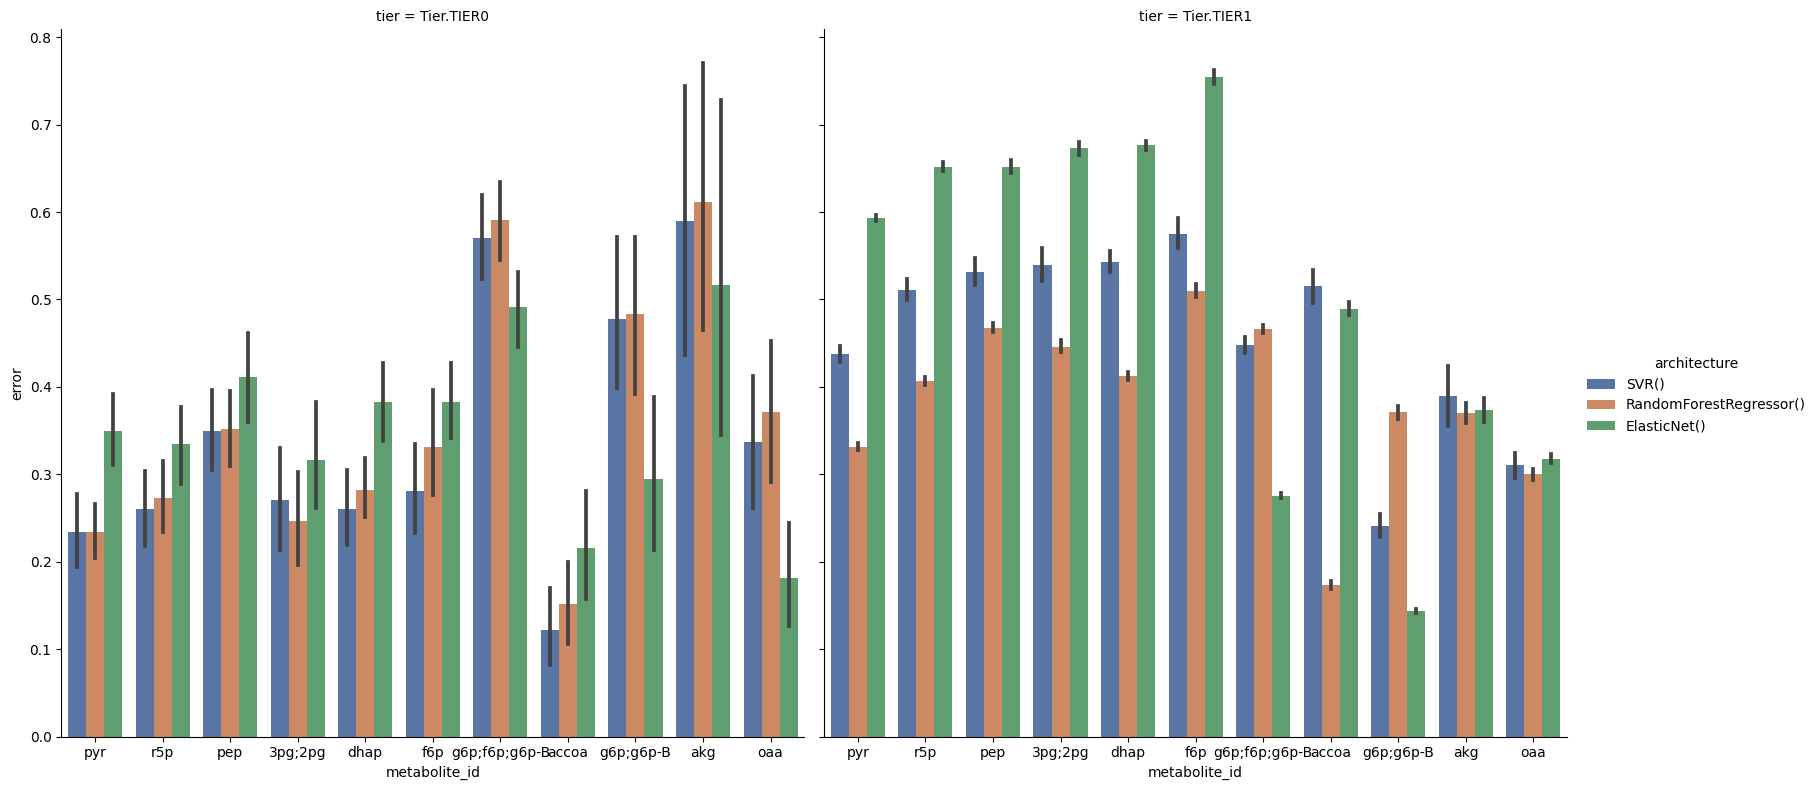

In [20]:
_df = test_pred_df[test_pred_df['architecture'] != 'all']
_df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')

g = sns.catplot(
    data=_df, 
    col='tier',
    kind='bar',
    x='metabolite_id',
    y='error',
    hue='architecture',
    palette='deep',
    height=8,
)

axes = g.figure.axes

axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Mean absolute error (y true vs y pred)", title="MAE per metabolite with their variance")
plt.tight_layout()

# Explanation

In [21]:
import glob

root_dir = "/home/tijmen/tudelft/thesis/metaengineering"
strategy = Strategy.ALL
tier = Tier.TIER0

tiers = [Tier.TIER0, Tier.TIER1]
strategies = [Strategy.ALL, Strategy.METABOLITE_CENTRIC, Strategy.ONE_VS_ALL]

def get_lime_explanations(tier, strategy):
    def get_frame(path, metabolite_id):
        explanation_df = pd.read_json(path) \
            .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
            .assign(strategy=strategy).assign(tier=tier).assign(frame_id=metabolite_id)
        return explanation_df

    root_dir = "/home/tijmen/tudelft/thesis/metaengineering/"
    paths = glob.glob(f"{root_dir}/explanation/{tier}/lime/{strategy}_*.json")
    metabolite_ids = [path.rsplit('/', 1)[1].removesuffix('.json').removeprefix(f'{strategy}_') for path in paths]
    print(paths)
    print(metabolite_ids)
    print(f'{root_dir}/explanation/{tier}/lime/{strategy}_all.json')
    explanation_df = pd.concat([get_frame(path, metabolite_id) for path, metabolite_id in zip(paths, metabolite_ids)])
        
    
    return explanation_df

explanation_df = pd.concat([get_lime_explanations(tier, strategy) for tier, strategy in itertools.product(tiers, strategies)])
explanation_df

['/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.ALL_all.json']
['all']
/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.ALL_all.json
['/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_f6p.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_g6p;f6p;g6p-B.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_oaa.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_r5p.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_akg.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_dhap.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_g6p;g6

,KO_ORF,metabolite_id,exp_enzymes,exp_weights,y_true,y_pred,official_name,kegg_id,pathway,method,Order,strategy,tier,frame_id
0,YBR059C,pyr,"[YER012W, YGR254W, YPL262W, YML008C, YGR001C, ...","[-0.0308304737, 0.0254235911, 0.0226005415, -0...",0.844023,0.831159,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
1,YPL141C,pyr,"[YER012W, YGR254W, YLR438W, YGR175C, YPL262W, ...","[-0.0352542928, 0.030518200800000003, 0.026307...",0.039513,-0.249019,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
4,YDR490C,pyr,"[YER012W, YGR254W, YML008C, YPL262W, YGR175C, ...","[-0.0376251138, 0.0301763853, -0.0251105116, 0...",0.028086,-0.478923,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
15,YGL179C,pyr,"[YER012W, YGR254W, YLR438W, YGR175C, YPL262W, ...","[-0.035160843000000004, 0.0294499134, 0.026419...",0.533595,0.799462,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
27,YPL236C,pyr,"[YER012W, YLR438W, YGR175C, YML008C, YPL262W, ...","[-0.0387017017, 0.0260341038, -0.0250271360000...",0.580472,0.729733,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9123,YJL141C,r5p,"[interaction_2, interaction_16, interaction_24...","[-0.011256954500000001, -0.0097476184, -0.0069...",0.261479,0.908050,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1,r5p
9124,YJL141C,r5p,"[interaction_2, interaction_16, interaction_24...","[-0.0112566064, -0.009747349800000001, -0.0069...",0.249941,0.908050,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1,r5p
9125,YJL141C,r5p,"[interaction_2, interaction_16, interaction_24...","[-0.0112569029, -0.0097475089, -0.006939211000...",0.273099,0.908050,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1,r5p
9126,YJL141C,r5p,"[interaction_2, interaction_16, interaction_24...","[-0.0112570575, -0.0097476698, -0.006939438500...",0.279312,0.908050,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1,r5p


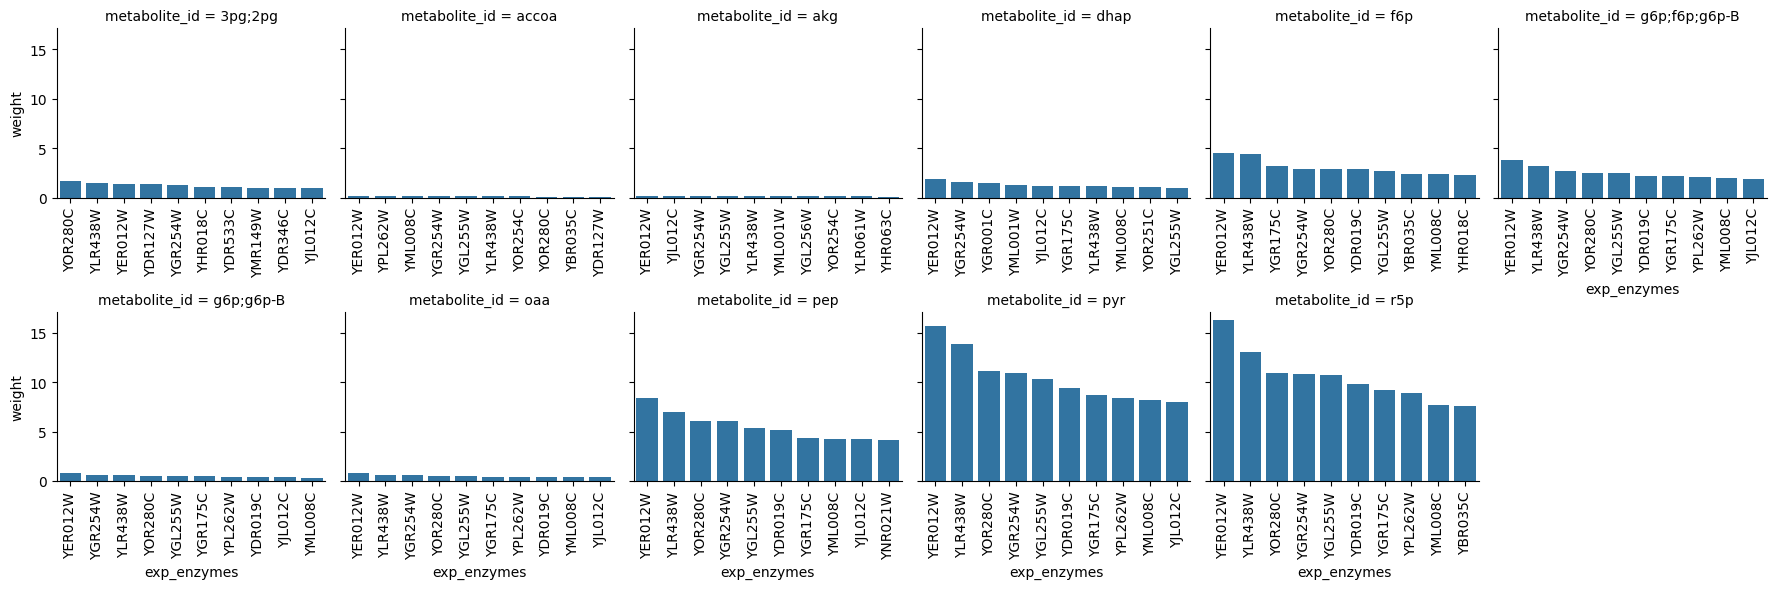

In [22]:
_df = explanation_df[explanation_df['tier'] == Tier.TIER0].explode(['exp_enzymes', 'exp_weights']).groupby(by=['metabolite_id', 'exp_enzymes'])['exp_weights'].sum().abs() \
    .to_frame('weight').reset_index() \
    .groupby('metabolite_id').apply(lambda x: x.sort_values(by='weight', ascending=False).head(10))

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='weight')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

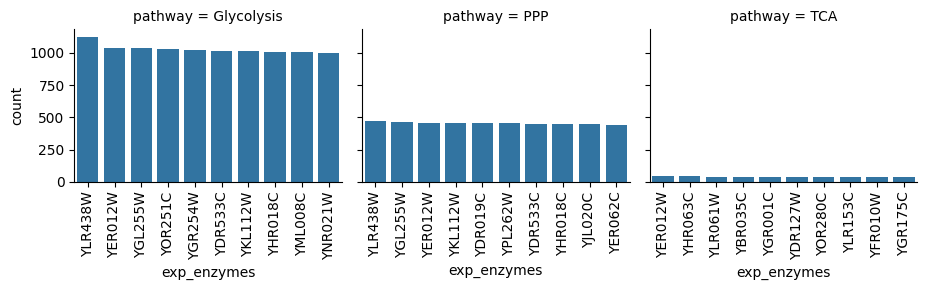

In [23]:
_df = explanation_df[explanation_df['tier'] == Tier.TIER0].explode(['exp_enzymes', 'exp_weights']) \
    .groupby(['pathway', 'exp_enzymes'])['KO_ORF'].count().to_frame('count').reset_index() \
    .groupby('pathway', as_index=False).apply(lambda x: x.sort_values(by='count', ascending=False).head(10)) \
    
_df = _df.merge(
    right=explanation_df.groupby('pathway').size().to_frame('total'),
    left_on='pathway',
    right_on='pathway'
)
# _df['percentage'] = _df['count'] / _df['total']

g = sns.FacetGrid(data=_df, col='pathway', col_wrap=6, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='count')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()